# 2D Design DDW T3 2021

## CC07 G09:
- Ng Jie Lin 1005476
- Umang Gupta 1005393
- Lee Cheng Xin 1005056
- Yeo Ke Wei 1005165

# Part 1

The COVID death target that our group will be working towards will be in terms of the **Percentage of Deaths to the total population per month (PDPM)** for each country

Our group hypothesises 2 features (ie predictor variables) that has strong correlation to PDPM. Namely, the **Gross Domestic Product (GDP)** and **Proportion of population above 65 years old (PEP)** for each country.

[Dataset Site](https://github.com/owid/covid-19-data/tree/master/public/data)
(Last taken on 23/11/2021) By using excel, we isolated the features and target described above. 

***
*Disclaimer: The prediction of PDPM using GDP and PEP is applicable to only data collated to 23/11/2021 (ie a fixed point in time). Time is not a feature used in this model.*
# Code
The functions shown below will be used to create and test our multi-linear regression models. We will be using Mean Square Error to compare the accuracies between models.

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_z(df):
    return (df-df.mean(axis=0))/df.std(axis=0)
def get_features_targets(df, feature_names, target_names):
    df_feature,df_target = df.loc[:,feature_names],df.loc[:,target_names,]
    return df_feature, df_target
def prepare_feature(df_feature): #changes from LR, add the cols to add more to column in matrix
    feature_val = df_feature.to_numpy()
    ones = np.ones((df_feature.shape[0], 1)) #n rows and 1 column of ones
    x = np.concatenate((ones,feature_val), axis = 1) #axis = 1 means increase no. of col per row (add side by side)
    return x
def prepare_target(df_target):
    return df_target.to_numpy()
def predict(df_feature, beta):
    X = prepare_feature((normalize_z(df_feature)))
    return predict_norm(X,beta)
def predict_norm(X, beta):
    return np.matmul(X,beta)
def split_data(df_feature, df_target, random_state=100, test_size=0.5):
    np.random.seed(random_state)
    rowsize_feature = df_feature.shape[0]
    test_idxs_f = np.random.choice(rowsize_feature, size = int(rowsize_feature*test_size), replace=False)
    np.random.seed(random_state)
    rowsize_target = df_target.shape[0]
    test_idxs_t =np.random.choice(rowsize_target, size = int(rowsize_target*(test_size)), replace=False)
    df_feature_test = df_feature.loc[test_idxs_f,:]
    df_feature_train = df_feature.drop(index=test_idxs_f)
    df_target_test = df_target.loc[test_idxs_t,:]
    df_target_train = df_target.drop(index=test_idxs_t)
    return df_feature_train, df_feature_test, df_target_train, df_target_test
def mean_squared_error(target, pred):
    num_of_samp = target.shape[0]
    return (1/num_of_samp)*np.sum((target-pred)**2)
def compute_cost(X, actual_y, beta):
    J,sample_size = 0,X.shape[0]
    error = np.matmul(X,beta) - actual_y
    error_sq = np.matmul(error.T,error)
    J = (1/(sample_size*2))*error_sq 
    return J[0][0]
def gradient_descent_multi(X, y, beta, alpha, num_iters):
    J_storage = []
    for i in range(0, num_iters):
        derivative_error = (1/(X.shape[0]))*np.matmul(X.T,(np.matmul(X,beta)-y)) 
        beta = beta - alpha * derivative_error
        J_storage.append(compute_cost(X,y,beta))
    return beta, J_storage
def subplot_display(x,row,col,f_label,t_label,feature,target,title_str=""):
    x[row][col].plot(feature) if target.empty else x[row][col].scatter(feature, target)
    x[row][col].set(xlabel=f_label, ylabel=t_label, title=title_str)

# Hypotheses & Cleaning of data
Intuitively, our team hypothesises the following of our features to the PDPM: 
- GDP is inversely related to PDPM
- PEP is linearly related to PDPM

As such we will clean the raw data by removing outliers based on the following criteria:
- Countries with <600 Days with Death: Insufficient data
- Countries with low GDP per capita: [Unaccounted Economies](https://www.weforum.org/agenda/2018/01/gdp-frog-matchbox-david-pilling-growth-delusion/)
- Countries with low PDPM: Suspected of [under-reporting](https://www.cfr.org/in-brief/how-much-are-countries-underreporting-covid-19-cases-and-deaths)


**Computed data**
- Days with Death: time period from start date to end date in days 
- Months with Death: time period from start date to end date in months ( div by 31)
- Total Death = sum of new deaths over the period between start date and end date
- **PDPM = Total Deaths / Months with Death**

The graphs are plotted out to display the correlation between our features and PDPM.

[Text(0.5, 0, 'PEP'), Text(0, 0.5, 'PDPM'), Text(0.5, 1.0, 'PDPM vs PEP')]

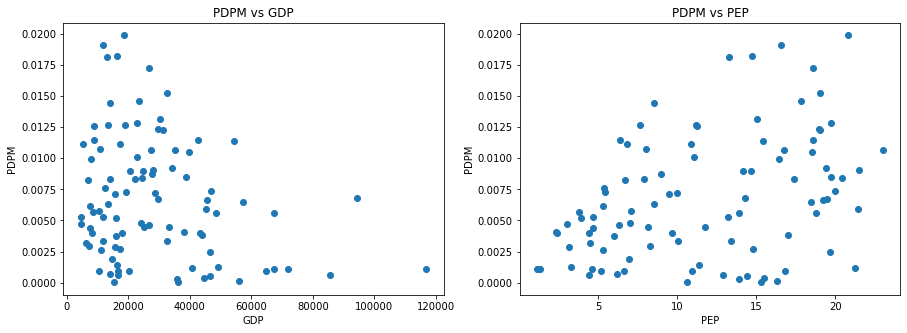

In [158]:
#Read the CSV file, Set target label & feature labels 
df, target_label,feature1_label,feature2_label = pd.read_csv("Death_Dataset3.csv"),"PDPM","GDP","PEP"
# Extract the features and the targets
df_features, df_target = get_features_targets(df,[feature1_label,feature2_label],[target_label])

fig , axes = plt.subplots(1,2,figsize = (15,5))

axes[0].scatter(df_features[feature1_label], df_target)
axes[0].set(xlabel= feature1_label, ylabel = target_label, title = target_label + " vs " + feature1_label)
axes[1].scatter(df_features[feature2_label], df_target)
axes[1].set(xlabel= feature2_label, ylabel = target_label, title = target_label + " vs " + feature2_label)

We observe from the PDPM vs. GDP graph (left) that the relationship is not linear, hence we transformed the GDP feature to **1/GDP** and **LOG(GDP)** and calculated the MSE to measure of the quality of our estimation model. R^2 measurement was not used as it does not show whether the right model is chosen and the predicted capacity of the obtained fit.

The code below executes the described operation, displays all the outputs in a subplot and calculates the Beta coefficients of our model.
$$y =  \beta_0 + \beta_1 x_1 + \beta_2 x_2$$
$$x_1 = GDP$$
$$x_2 = PEP$$

The PDPM vs. PEP still displays outliers that has PDPM < 0.0025% while PEP > 15%. This may indicate that the data could require more trimming but for our current model, we will continue to use these countries to explore the effect of such outliers on our regression model.

MSE GDP : 1.74974856676384e-05
| Beta 0 : [0.00675737] | Beta 1 : [-0.00177525] | Beta 2 : [0.00230043] |
MSE 1/GDP : 1.8834257365831764e-05
| Beta 0 : [0.00675737] | Beta 1 : [0.00140985] | Beta 2 : [0.00249401] |
MSE LOG(GDP) : 1.7449170139342724e-05
| Beta 0 : [0.00675737] | Beta 1 : [-0.00189291] | Beta 2 : [0.00264044] |


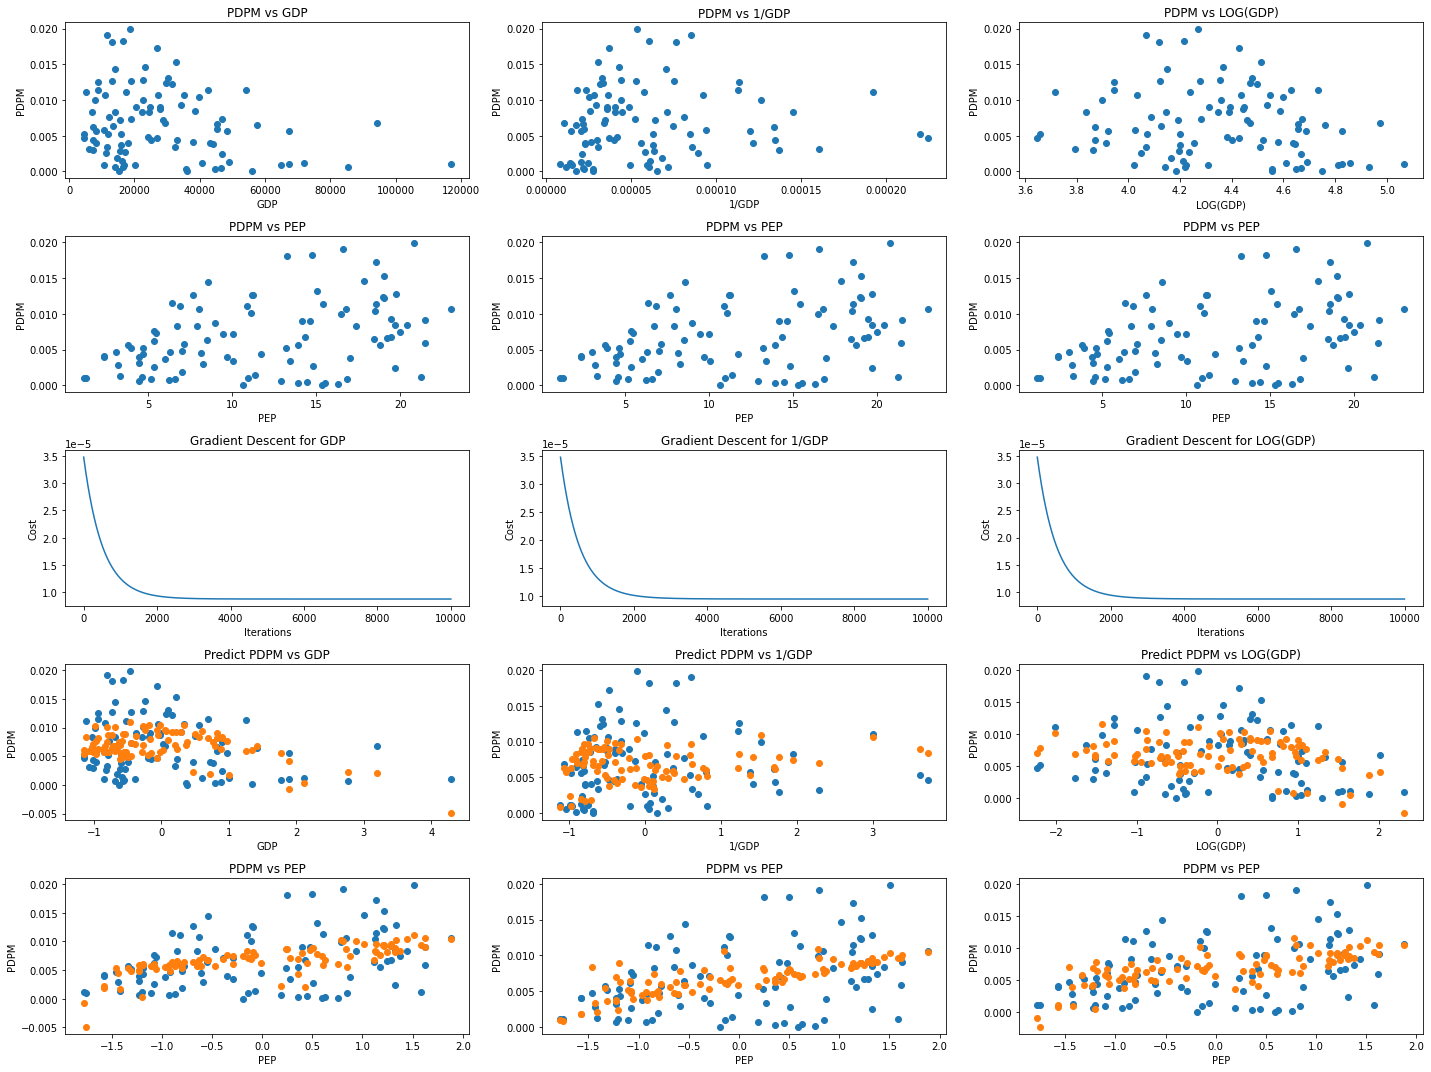

In [159]:
#Set transformed GDP labels
feature1_label_transform1,feature1_label_transform2 = "1/GDP","LOG(GDP)"
feature_arr = [feature1_label,feature1_label_transform1,feature1_label_transform2]
# Extract the features and the targets
df_features_t1, df_target = get_features_targets(df,[feature1_label_transform1,feature2_label],[target_label])
df_features_t2, df_target = get_features_targets(df,[feature1_label_transform2,feature2_label],[target_label])
#Creating Subplots to put multiple graphs
fig , axes = plt.subplots(5,3,figsize = (20,15))
#Sotring of beta,pred,mse for each GDP transformation
betas,preds,mses = [None]*3,[None]*3,[None]*3
#Repeats the illustration and applies MLR. Finds the Beta coefficients and model prediction for each GDP transformation
for col_GDP in range(len(feature_arr)): 
    if col_GDP == 0:
        df_features_z,feature = normalize_z(df_features),df_features
    elif col_GDP == 1:
        df_features_z,feature = normalize_z(df_features_t1),df_features_t1
    elif col_GDP == 2:
        df_features_z,feature = normalize_z(df_features_t2),df_features_t2
    #Plotting each GDP transformation
    subplot_display(axes,0,col_GDP,feature_arr[col_GDP],target_label,feature[feature_arr[col_GDP]],df_target,target_label+" vs "+feature_arr[col_GDP])
    #Change the features and the target to numpy array using the prepare functions
    X, target = prepare_feature(df_features_z), prepare_target(df_target)
    iterations, alpha = 10000 , 0.001
    beta = np.zeros((X.shape[1],1)) #b0 + b1x1 + b2x2
    betas[col_GDP], J_storage = gradient_descent_multi(X, target, beta, alpha, iterations)
    #Plotting Gradient Descent, Predicted PDPM vs GDP, Predicted PDPM vs PEP
    subplot_display(axes,1,col_GDP,feature2_label,target_label,df_features[feature2_label],df_target,target_label +" vs "+feature2_label)# PDPM vs PEP
    subplot_display(axes,2,col_GDP,"Iterations","Cost",J_storage,pd.DataFrame(),"Gradient Descent for "+ feature_arr[col_GDP])# Gradient Descent of Cost
    preds[col_GDP] = predict(df_features_z,betas[col_GDP])
    subplot_display(axes,3,col_GDP,feature_arr[col_GDP],target_label,df_features_z[feature_arr[col_GDP]],df_target,"Predict " + target_label + " vs " + feature_arr[col_GDP])#PDPM vs GDP
    axes[3][col_GDP].scatter(df_features_z[feature_arr[col_GDP]], preds[col_GDP])#Predicted PDPM vs GDP
    subplot_display(axes,4,col_GDP,feature2_label,target_label,df_features_z[feature2_label],df_target,target_label +" vs "+feature2_label)#PDPM vs PEP
    axes[4][col_GDP].scatter(df_features_z[feature2_label], preds[col_GDP])#Predicted PDPM vs PEP
    #Calculate MSE to determine accuracy
    target = prepare_target(df_target)
    mses[col_GDP] = mean_squared_error(target,preds[col_GDP])
    #Printing out the MSE & Beta Coefficient for each linear regression
    print("MSE {} : {}".format(feature_arr[col_GDP],mses[col_GDP]))
    beta_str = "|"
    for i in range(len(betas[col_GDP])):
        beta_str += " Beta {} : {} |".format(i,betas[col_GDP][i])
    print(beta_str)
fig.tight_layout()#To fit plots within figure cleanly

# Residual Plotting
[Residual plots](https://blog.minitab.com/en/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis) was used to observe the error (difference between the expected and observed value) and determine if our model is valid. If the error is unpredictable (ie no visible trend), that indicates that our model is good at predicting the expected value.

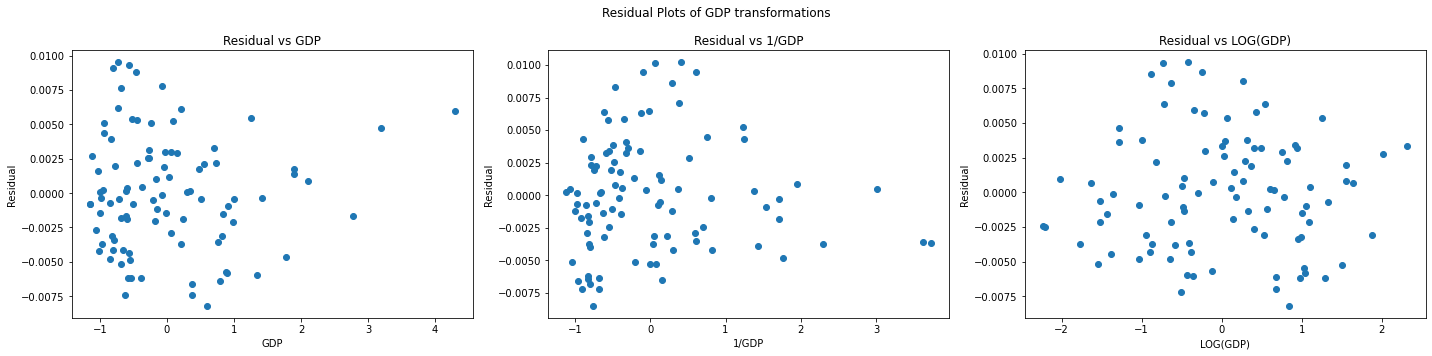

In [160]:
#Graphing the Residual Plots (Residual = Response - Deterministic)
R_fig , R_axes = plt.subplots(1,3,figsize = (20,5))
errors= [None]*3
for col in range(len(feature_arr)):
    if col == 0:
        df_features_z = normalize_z(df_features)
    elif col == 1:
        df_features_z = normalize_z(df_features_t1)
    elif col == 2:
        df_features_z = normalize_z(df_features_t2)
    errors[col] = df_target - preds[col]
    R_axes[col].scatter(df_features_z[feature_arr[col]], errors[col])
    R_axes[col].set(xlabel= feature_arr[col], ylabel = "Residual", title =  "Residual vs " + feature_arr[col])
R_fig.suptitle("Residual Plots of GDP transformations")
R_fig.tight_layout()#To fit plots within figure cleanly

# Part 1 Conclusion
We can conclude that LOG(GDP) transformation is the best fit of our model due to the following:
- MSE for LOG(GDP) transformation has the lowest in comparison to the other models
- Residual plot of the LOG(GDP) is the most random and unpredictable compared to GDP and 1/GDP transformation

There is also linear correlation of GDP and PEP to PDPM as we hypothesised.

**MSE** (Smallest to largest)
- `LOG(GDP): 1.7449170139342724e-05`
- GDP: 1.74974856676384e-05
- 1/GDP: 1.8834257365831764e-05

# Part 2

### Overview About the Problem

Describe here the problem you are trying to solve.

### Dataset

Describe here your data set. Put the link to the sources of your dataset. Describe your data and what are the columns.

Put some Python codes here to describe and visualize your data.

In [161]:
# put Python code to read and describe your data

### Features and Target Preparation

Describe here what are the features you use and why these features. Put any Python codes to prepare and clean up your features. 

Do the same thing for the target. Describe your target and put any codes to prepare your target.

In [162]:
# put Python code to prepare your featuers and target

### Building Model

Describe your model. Is this Linear Regression or Logistic Regression? Put any other details about the model. Put the codes to build your model.

In [163]:
# put Python code to build your model

### Evaluating the Model

Describe your metrics and how you want to evaluate your model. Put any Python code to evaluate your model. Use plots to have a visual evaluation.

In [164]:
# put Python code to evaluate the model and to visualize its accuracy

### Improving the Model

Discuss any steps you can do to improve the models. Put any python codes. You can repeat the steps above with the codes to show the improvement in the accuracy. 

### Discussion and Analysis

Discuss your model and accuracy in solving the problem. Analyze the results of your metrics. Put any conclusion here.